In [ ]:
import pandas as pd
from bs4 import BeautifulSoup
import re

def clean_text(text):
    return re.sub(r'\s+', ' ', text).strip()

def parse_html(html):
    if not isinstance(html, str) or html.strip() == "":
        return "", ""
    soup = BeautifulSoup(html, "html.parser")

    
    title_tag = soup.find('title')
    if title_tag and title_tag.get_text(strip=True):
        title = title_tag.get_text(strip=True)
    else:
        h1 = soup.find('h1')
        title = h1.get_text(strip=True) if h1 else ""

    
    content = ""
    for tag_name in ['article', 'main']:
        tag = soup.find(tag_name)
        if tag:
            content = tag.get_text(" ", strip=True)
            break
    if not content:
        parts = [p.get_text(" ", strip=True) for p in soup.find_all(['p','h2','h3']) if p.get_text(strip=True)]
        content = " ".join(parts)
    
    return title, clean_text(content)


df = pd.read_csv("data.csv")


df['title'], df['body_text'] = zip(*df['html_content'].map(parse_html))
df['word_count'] = df['body_text'].apply(lambda x: len(re.findall(r'\w+', x)))

parsed_path = "parsed_content.csv"
df[['url','title','body_text','word_count']].to_csv(parsed_path, index=False)
print("✅ Parsed HTML saved to:", parsed_path)


✅ Parsed HTML saved to: parsed_content.csv


In [5]:
import os
os.path.exists("parsed_content.csv")


True

In [13]:
import pandas as pd

parsed_df = pd.read_csv("parsed_content.csv")
parsed_df.head()


,url,title,body_text,word_count
0,https://www.cm-alliance.com/cybersecurity-blog,Cyber Security Blog,Cyber Crisis Tabletop Exercise Cyber Security ...,341
1,https://www.varonis.com/blog/cybersecurity-tips,Top 10 Cybersecurity Awareness Tips: How to St...,Cybersecurity is gaining more importance globa...,1743
2,https://www.cisecurity.org/insights/blog/11-cy...,11 Cyber Defense Tips to Stay Secure at Work a...,Home Insights Blog Posts 11 Cyber Defense Tips...,1091
3,https://www.cisa.gov/topics/cybersecurity-best...,Cybersecurity Best Practices | Cybersecurity a...,Cybersecurity Best Practices CISA provides inf...,851
4,https://www.qnbtrust.bank/Resources/Learning-C...,NaN,NaN,0


# Text Preprocessing & Feature Engineering 

In [ ]:


import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer


def clean_text(text: str) -> str:
    """
    Lowercases, removes punctuation/numbers, and normalizes spaces.
    """
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


def split_sentences(text: str):
    """
    Splits text into sentences using basic punctuation delimiters.
    """
    if not text:
        return []
    return re.split(r'[.!?;\n]+', text)


def flesch_reading_ease(text: str) -> float:
    """
    Computes a simple Flesch Reading Ease score.
    """
    if not text:
        return 0.0
    sentences = split_sentences(text)
    words = re.findall(r"\w+", text)
    total_sentences = max(1, len(sentences))
    total_words = max(1, len(words))
    syllables = sum(len(re.findall(r'[aeiouy]+', w)) for w in words)
    score = 206.835 - 1.015 * (total_words / total_sentences) - 84.6 * (syllables / total_words)
    return round(score, 2)


def extract_top_keywords(tfidf_matrix, feature_names, top_n=5):
    """
    Extracts top N keywords per document from a TF-IDF matrix.
    """
    keywords_list = []
    for row in tfidf_matrix:
        coefs = row.toarray().ravel()
        top_idx = np.argsort(coefs)[-top_n:][::-1]
        top_terms = [feature_names[i] for i in top_idx if coefs[i] > 0]
        keywords_list.append("|".join(top_terms))
    return keywords_list



def build_features(input_csv_path: str, output_csv_path: str = "features.csv"):
    """
    Builds NLP features from a parsed HTML dataset.
    Saves results as a new CSV file.
    """

    df = pd.read_csv(input_csv_path)

    if "body_text" not in df.columns:
        raise ValueError("Missing 'body_text' column in input file.")

    df["clean_text"] = df["body_text"].apply(clean_text)

    df["word_count"] = df["clean_text"].apply(lambda x: len(re.findall(r'\w+', x)))
    df["sentence_count"] = df["clean_text"].apply(lambda x: len(split_sentences(x)))
    df["flesch_reading_ease"] = df["clean_text"].apply(flesch_reading_ease)

   
    vectorizer = TfidfVectorizer(stop_words="english", max_features=3000)
    tfidf_matrix = vectorizer.fit_transform(df["clean_text"])

    
    if hasattr(vectorizer, "get_feature_names_out"):
        feature_names = np.array(vectorizer.get_feature_names_out())
    else:
        feature_names = np.array(vectorizer.get_feature_names())


   
    df["top_keywords"] = extract_top_keywords(tfidf_matrix, feature_names)

    
    embeddings = tfidf_matrix.toarray()
    df["embedding"] = [emb[:20].round(6).tolist() for emb in embeddings]

    
    columns_to_save = [
        "url",
        "word_count",
        "sentence_count",
        "flesch_reading_ease",
        "top_keywords",
        "embedding"
    ]
    df[columns_to_save].to_csv(output_csv_path, index=False)

    print(f" Features extracted and saved to: {output_csv_path}")
    return df[columns_to_save]





df_features = build_features("parsed_content.csv")

✅ Features extracted and saved to: features.csv


3. Duplicate Detection (20%)


In [ ]:


import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def detect_duplicates(
    input_csv_path: str,
    sim_threshold: float = 0.80,
    output_dupes_csv: str = "duplicate_pairs.csv",
    output_thin_csv: str = "thin_content.csv"
):
    """
    Detects near-duplicate and thin content pages.
    """

    df = pd.read_csv(input_csv_path)

    if "embedding" not in df.columns:
        raise ValueError("Input CSV must contain an 'embedding' column.")

   
    def parse_embedding(x):
        try:
            
            return np.array(eval(x), dtype=float)
        except Exception:
            return np.array([])

    df["embedding_array"] = df["embedding"].apply(parse_embedding)

    
    embeddings = np.vstack(df["embedding_array"].values)
    print(f" Loaded {len(df)} embeddings, dim = {embeddings.shape[1]}")

  
    sim_matrix = cosine_similarity(embeddings)

    
    dup_pairs = []
    n = len(df)
    for i in range(n):
        for j in range(i + 1, n):
            sim_score = sim_matrix[i, j]
            if sim_score >= sim_threshold:
                dup_pairs.append({
                    "url1": df.loc[i, "url"],
                    "url2": df.loc[j, "url"],
                    "similarity": round(float(sim_score), 3)
                })

    df_dupes = pd.DataFrame(dup_pairs)
    df_dupes.to_csv(output_dupes_csv, index=False)

   
    df["is_thin"] = df["word_count"].apply(lambda x: x < 500)
    df_thin = df[["url", "word_count", "is_thin"]]
    df_thin.to_csv(output_thin_csv, index=False)

    
    total_pages = len(df)
    duplicate_pairs = len(df_dupes)
    thin_pages = df["is_thin"].sum()
    thin_percent = round((thin_pages / total_pages) * 100, 2)

    print("\n📊 SUMMARY REPORT")
    print(f"Total pages analyzed : {total_pages}")
    print(f"Duplicate pairs       : {duplicate_pairs}")
    print(f"Thin content pages    : {thin_pages} ({thin_percent}%)")
    print(f"✅ Duplicate pairs saved → {output_dupes_csv}")
    print(f"✅ Thin content saved  → {output_thin_csv}")

    return df_dupes, df_thin


df_dupes, df_thin = detect_duplicates("features.csv")

✅ Loaded 81 embeddings, dim = 20

📊 SUMMARY REPORT
Total pages analyzed : 81
Duplicate pairs       : 74
Thin content pages    : 34 (41.98%)
✅ Duplicate pairs saved → duplicate_pairs.csv
✅ Thin content saved  → thin_content.csv


📊 Baseline Accuracy (word_count only): 0.56

🧾 Model Performance:

              precision    recall  f1-score   support

         Low       1.00      1.00      1.00        25

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25

Overall Accuracy: 1.00
Weighted F1-score: 1.00
Baseline Accuracy: 0.56


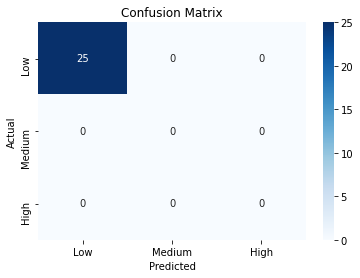


🔍 Top Features:
               Feature  Importance
0           word_count         0.0
1       sentence_count         0.0
2  flesch_reading_ease         0.0


In [ ]:

# STEP 4: CONTENT QUALITY SCORING

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

def train_quality_classifier(input_csv_path: str):
    """
    Train and evaluate a model to classify content quality (Low / Medium / High)
    """

    
    df = pd.read_csv(input_csv_path)

    required_cols = ["word_count", "sentence_count", "flesch_reading_ease"]
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    
    def label_quality(row):
        if row["word_count"] > 1500 and 50 <= row["flesch_reading_ease"] <= 70:
            return "High"
        elif row["word_count"] < 500 or row["flesch_reading_ease"] < 30:
            return "Low"
        else:
            return "Medium"

    df["quality_label"] = df.apply(label_quality, axis=1)

    
    X = df[["word_count", "sentence_count", "flesch_reading_ease"]]
    y = df["quality_label"]

    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    
    def baseline_predict(row):
        if row["word_count"] > 1500:
            return "High"
        elif row["word_count"] < 500:
            return "Low"
        else:
            return "Medium"

    y_pred_baseline = X_test.apply(baseline_predict, axis=1)
    baseline_acc = accuracy_score(y_test, y_pred_baseline)
    print(f" Baseline Accuracy (word_count only): {baseline_acc:.2f}")

   
    model = RandomForestClassifier(random_state=42, n_estimators=150)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

   
    print("\n Model Performance:\n")
    print(classification_report(y_test, y_pred))
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    print(f"Overall Accuracy: {acc:.2f}")
    print(f"Weighted F1-score: {f1:.2f}")
    print(f"Baseline Accuracy: {baseline_acc:.2f}")

    
    cm = confusion_matrix(y_test, y_pred, labels=["Low", "Medium", "High"])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Low", "Medium", "High"],
                yticklabels=["Low", "Medium", "High"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    
    if hasattr(model, "feature_importances_"):
        feature_importance = pd.DataFrame({
            "Feature": X.columns,
            "Importance": model.feature_importances_
        }).sort_values(by="Importance", ascending=False)
        print("\n🔍 Top Features:")
        print(feature_importance.head(3))
    else:
        print("⚠️ Model does not support feature importance.")

    return model, df
#Example
model, df_qualified = train_quality_classifier("features.csv")

In [2]:
!pip install textstat



In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import textstat
import json

def analyze_url(url, reference_csv=None, vectorizer=None, threshold=0.8):
    """
    Analyze a URL: scrape page, extract features, compute quality, detect duplicates.
    
    Parameters:
    - url (str): target URL
    - reference_csv (str): optional CSV with previous texts
    - vectorizer: optional pre-fitted TF-IDF vectorizer
    - threshold (float): similarity threshold for duplicates
    
    Returns:
    - dict: features, quality, similar URLs
    """
    try:
       
        headers = {
            "User-Agent": (
                "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                "AppleWebKit/537.36 (KHTML, like Gecko) "
                "Chrome/118.0.5993.90 Safari/537.36"
            )
        }
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        html_content = response.text

        
        soup = BeautifulSoup(html_content, "html.parser")
        for tag in soup(["script", "style", "noscript"]):
            tag.decompose()
        text = " ".join(soup.get_text(separator=" ").split())

        
        word_count = len(text.split())
        readability = round(textstat.flesch_reading_ease(text), 2)
        is_thin = word_count < 500

        
        if word_count > 1500 and 50 <= readability <= 70:
            quality_label = "High"
        elif word_count < 500 or readability < 30:
            quality_label = "Low"
        else:
            quality_label = "Medium"

       
        similar_to = []
        if reference_csv:
            df_ref = pd.read_csv(reference_csv)
            if "clean_text" not in df_ref.columns:
                raise ValueError("Reference CSV must have 'clean_text' column.")
            if vectorizer is None:
                vectorizer = TfidfVectorizer(stop_words="english")
            tfidf_ref = vectorizer.fit_transform(df_ref["clean_text"])
            tfidf_new = vectorizer.transform([text])
            sim_matrix = cosine_similarity(tfidf_new, tfidf_ref).flatten()
            df_ref["similarity"] = sim_matrix
            similar_to = df_ref[df_ref["similarity"] > threshold][["url", "similarity"]].to_dict(orient="records")

       
        result = {
            "url": url,
            "word_count": word_count,
            "readability": readability,
            "quality_label": quality_label,
            "is_thin": is_thin,
            "similar_to": similar_to
        }

        return result

    except Exception as e:
        return {"error": str(e), "url": url}



# Example usage

result = analyze_url(
    "https://www.cnn.com/2024/06/03/politics/us-mexico-border-immigration-executive-actions/index.html",
    reference_csv="parsed_content.csv"  
)
print(json.dumps(result, indent=2))


{
  "error": "404 Client Error: OK for url: https://edition.cnn.com/2024/06/03/politics/us-mexico-border-immigration-executive-actions/index.html",
  "url": "https://www.cnn.com/2024/06/03/politics/us-mexico-border-immigration-executive-actions/index.html"
}
